# Goal of the project
Analyze the food delivery company's data to uncover facts about it and improve its operations. Different KPIs were calculated during the project to measure the company's performance.

# Project Overview
The project consists of the following parts:

1) Finance metrics calculation (Revenue, Cost, and Profit).

2) User-centric metrics calculation (new registrations, active users, growth, and retention).

3) Unit economics and distributions

4) Generating Executive report

# Part 1. Finance metrics calculation (Revenue, Cost, Profit)

## Revenue calculation

**Calculating total revenue**

The total revenue that the company generated from users was calculated using a formula for revenue and joining two tables.

In [3]:
-- Calculate revenue
SELECT SUM(meal_price*order_quantity) AS revenue
  FROM meals.csv
  JOIN orders.csv ON meals.meal_id = orders.meal_id

,revenue
0,382205.75


**Revenue per week**

In this example, calculating weekly revenue was used to evaluate the success of the marketing campaign, with the number of ads increasing each week through the end of the month. Understanding revenue per week enabled an assessment of whether there were trends in revenue growth during a specific month of the marketing campaign.

In [3]:
SELECT DATE_TRUNC('week', order_date) :: DATE AS delivr_week,
       -- Calculate revenue
       SUM(meal_price * order_quantity) AS revenue
  FROM meals.csv
  JOIN orders.csv ON meals.meal_id = orders.meal_id
-- Keep only the records in June 2018
WHERE DATE_TRUNC('month', order_date) = '2018-06-01'
GROUP BY delivr_week
ORDER BY delivr_week ASC;

,delivr_week,revenue
0,2018-05-28 00:00:00+00:00,680.75
1,2018-06-04 00:00:00+00:00,2037.75
2,2018-06-11 00:00:00+00:00,2275.00
3,2018-06-18 00:00:00+00:00,2234.50
4,2018-06-25 00:00:00+00:00,1994.50


## Cost calculation

**Calculating the Company's Top 5 Products by Overall Cost**

In this example, the goal was to determine the 5 products on which the company spent the most for stocking.

For analysis and cost calculation, the tables 'stock' and 'meals' were used. In the 'stock' table, each row represents a bulk purchase the company made to stock the meals it offers, with the stocking date, the ID of the stocked meal, and the quantity of that meal stocked. The 'meals' table contains:
- meal_price: the price the user pays the company for the meal
- meal_cost: the cost the company pays its eateries to stock the meal.

In [4]:
SELECT
  -- Calculate cost per meal ID
 meals.meal_id,
 SUM(meal_cost*stocked_quantity) AS cost
FROM meals.csv
JOIN stock.csv ON meals.meal_id = stock.meal_id
GROUP BY meals.meal_id
ORDER BY cost DESC
-- Only the top 5 meal IDs by purchase cost
LIMIT 5;

,meal_id,cost
0,4,6045.00
1,5,4212.00
2,0,3274.00
3,2,3025.75
4,6,2843.50


**Calculate average cost per month**

First, we can write a query to calculate the cost per month:

In [5]:
SELECT
  -- Calculate cost
  DATE_TRUNC('month', stocking_date)::DATE AS delivr_month,
  SUM(meal_cost*stocked_quantity) AS cost
FROM meals.csv
JOIN stock.csv ON meals.meal_id = stock.meal_id
GROUP BY delivr_month
ORDER BY delivr_month ASC;

,delivr_month,cost
0,2018-06-01 00:00:00+00:00,2222.75
1,2018-07-01 00:00:00+00:00,3594.25
2,2018-08-01 00:00:00+00:00,5365.75
3,2018-09-01 00:00:00+00:00,8480.00
4,2018-10-01 00:00:00+00:00,12488.75
5,2018-11-01 00:00:00+00:00,6277.75


Then we can wrap the previous query in a CTE:

In [ ]:
-- Declare a CTE named monthly_cost
WITH monthly_cost AS (
  SELECT
    DATE_TRUNC('month', stocking_date)::DATE AS delivr_month,
    SUM(meal_cost * stocked_quantity) AS cost
  FROM meals
  JOIN stock ON meals.meal_id = stock.meal_id
  GROUP BY delivr_month)

SELECT *
FROM monthly_cost;

Finally, we can find the average cost:

In [1]:
-- Declare a CTE named monthly_cost
WITH monthly_cost AS (
  SELECT
    DATE_TRUNC('month', stocking_date)::DATE AS delivr_month,
    SUM(meal_cost * stocked_quantity) AS cost
  FROM meals.csv
  JOIN stock.csv ON meals.meal_id = stock.meal_id
  GROUP BY delivr_month)

SELECT
  -- Calculate the average monthly cost before September
  AVG(cost)
FROM monthly_cost;

,"avg(""cost"")"
0,6404.875


## Profit calculation

The key profit metrics were determined:
- Profit per user / business unit: helps to identify the "best" users, those who bring the company the most money.
- Profit per meal: identifies the most profitable product.
- Profit per month: tracks profit over time, signaling whether or not the company is getting better at making money.

We can combine the calculations of revenue and cost using Common Table Expressions to calculate profit.

## Calculation profit per business unit

To calculate profit per business unit, we need:
- Calculate revenue per business unit in the revenue CTE.
- Calculate cost per business unit in the cost CTE.
- Join the two CTEs and calculate profit per business unit.

In [1]:
WITH revenue AS (
  -- Calculate revenue per business unit
  SELECT eatery,
         SUM(meal_price*order_quantity) AS revenue
    FROM meals.csv
    JOIN orders.csv ON meals.meal_id = orders.meal_id
   GROUP BY eatery),

  cost AS (
  -- Calculate cost per business unit
  SELECT eatery,
         SUM(meal_cost*stocked_quantity) AS cost
    FROM meals.csv
    JOIN stock.csv ON meals.meal_id = stock.meal_id
   GROUP BY eatery)

   -- Calculate profit per business unit
   SELECT revenue.eatery,
          revenue-cost AS profit
     FROM revenue
     JOIN cost ON revenue.eatery = cost.eatery
    ORDER BY profit DESC;

,eatery,profit
0,'Burgatorio',85705.00
1,'Bean Me Up Scotty',80625.75
2,'The Moon Wok',78156.50
3,'Leaning Tower of Pizza',58349.00
4,'Life of Pie',40940.25


## Calculating Profit per month

To calculate profit per month, we need:
- Calculate revenue per month in the revenue CTE.
- Calculate cost per month in the cost CTE.
- Join the two CTEs and calculate profit per month.

In [2]:
-- Set up the revenue CTE
WITH revenue AS ( 
	SELECT
		DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
		SUM(meal_price*order_quantity) AS revenue
	FROM meals.csv
	JOIN orders.csv ON meals.meal_id = orders.meal_id
	GROUP BY delivr_month),
-- Set up the cost CTE
  cost AS (
 	SELECT
		DATE_TRUNC('month', stocking_date) :: DATE AS delivr_month,
		SUM(meal_cost*stocked_quantity) AS cost
	FROM meals.csv
    JOIN stock.csv ON meals.meal_id = stock.meal_id
	GROUP BY delivr_month)
-- Calculate profit by joining the CTEs
SELECT
	revenue.delivr_month,
	revenue - cost AS profit
FROM revenue
JOIN cost ON revenue.delivr_month = cost.delivr_month
ORDER BY revenue.delivr_month ASC;

,delivr_month,profit
0,2018-06-01 00:00:00+00:00,6999.75
1,2018-07-01 00:00:00+00:00,6659.00
2,2018-08-01 00:00:00+00:00,5271.75
3,2018-09-01 00:00:00+00:00,1221.00
4,2018-10-01 00:00:00+00:00,-1968.25
5,2018-11-01 00:00:00+00:00,3645.75


# Part 2. User-Centric KPIs calculation

Calculation KPIs to track user activity such as: registrations, active users, user growth, retention rates.

## Registrations

### Registrations by month

The registrations KPI focuses on new users and counts registrations over time. It's good at measuring a company's success in attracting new users.

In [7]:
SELECT
  -- Get the earliest (minimum) order date by user ID
  user_id,
  MIN(order_date) AS reg_date
FROM updated_orders.csv
GROUP BY user_id
-- Order by user ID
ORDER BY user_id ASC;

,user_id,reg_date
0,0,2018-06-01 00:00:00+00:00
1,1,2018-06-01 00:00:00+00:00
2,2,2018-06-01 00:00:00+00:00
3,3,2018-06-01 00:00:00+00:00
4,4,2018-06-01 00:00:00+00:00
5,5,2018-06-01 00:00:00+00:00
6,6,2018-06-01 00:00:00+00:00
7,7,2018-06-01 00:00:00+00:00
8,8,2018-06-01 00:00:00+00:00
9,9,2018-06-01 00:00:00+00:00


In [5]:
-- CTE for determine reg_dates
WITH reg_dates AS (
  SELECT
    new_user_id AS user_id,
    MIN(order_date) AS reg_date
  FROM orders_modified.csv
  GROUP BY new_user_id)

SELECT
  -- Count the unique user IDs by registration month
  DATE_TRUNC('month', reg_date):: DATE AS delivr_month,
  COUNT(DISTINCT user_id) AS regs
FROM reg_dates
GROUP BY delivr_month
ORDER BY delivr_month ASC;

,delivr_month,regs
0,2018-06-01 00:00:00+00:00,123
1,2018-07-01 00:00:00+00:00,140
2,2018-08-01 00:00:00+00:00,157
3,2018-09-01 00:00:00+00:00,176
4,2018-10-01 00:00:00+00:00,199
5,2018-11-01 00:00:00+00:00,231
6,2018-12-01 00:00:00+00:00,278
7,2019-01-01 00:00:00+00:00,56


### Registrations running total

The Registrations Running Total by month is the total number of registered users in each month.

We can use this metric to know how many registered users we have overall by month.
To calculate a running total, we'll use a window function.

In [3]:
WITH reg_dates AS (
  SELECT
    new_user_id,
    MIN(order_date) AS reg_date
  FROM orders_modified_greater_variation.csv
  GROUP BY new_user_id),

  regs AS (
  SELECT
    DATE_TRUNC('month', reg_date) :: DATE AS delivr_month,
    COUNT(DISTINCT new_user_id) AS regs
  FROM reg_dates
  GROUP BY delivr_month)

SELECT
  -- Calculate the registrations running total by month
  delivr_month,
  SUM(regs) OVER (ORDER BY delivr_month ASC) AS regs_rt
FROM regs
-- Order by month in ascending order
ORDER BY delivr_month ASC;

,delivr_month,regs_rt
0,2018-06-01 00:00:00+00:00,123.0
1,2018-07-01 00:00:00+00:00,226.0
2,2018-08-01 00:00:00+00:00,337.0
3,2018-09-01 00:00:00+00:00,489.0
4,2018-10-01 00:00:00+00:00,689.0
5,2018-11-01 00:00:00+00:00,750.0
6,2018-12-01 00:00:00+00:00,775.0
7,2019-01-01 00:00:00+00:00,796.0
8,2019-02-01 00:00:00+00:00,797.0
9,2019-03-01 00:00:00+00:00,799.0


## Active users

### Monthly active users `(MAU)`

Using the active users KPI, we can focuse on existing users which counts the active users of a company's app over a time period, in our case by month. We can also use "Stickiness": the ratio of DAU (day active users) to MAU , measures how often users engage with a service on average. For example, if 's stickiness is 30%, then users use company's servise for 30% * 30 days in a month = 9 days each month on average.

To determine MAU:
- Select the month by truncating the order dates.
- Calculate MAU by counting the users for every month.
- Order by month in ascending order.

In [4]:
SELECT
  -- Truncate the order date to the nearest month
  DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
  -- Count the unique user IDs
  COUNT(DISTINCT new_user_id) AS mau
FROM orders_modified_greater_variation.csv
GROUP BY delivr_month
-- Order by month
ORDER BY delivr_month ASC;

,delivr_month,mau
0,2018-06-01 00:00:00+00:00,123
1,2018-07-01 00:00:00+00:00,226
2,2018-08-01 00:00:00+00:00,337
3,2018-09-01 00:00:00+00:00,489
4,2018-10-01 00:00:00+00:00,689
5,2018-11-01 00:00:00+00:00,750
6,2018-12-01 00:00:00+00:00,775
7,2019-01-01 00:00:00+00:00,124
8,2019-02-01 00:00:00+00:00,120
9,2019-03-01 00:00:00+00:00,119


### Tracking change MAU over time     

We will use a window function `LAG` for tracking changes in MAU over time.
Using window functions is convenient for comparing the current and previous months' monthly active users (MAUs).

The following query returns a table of MAUs and the previous month's MAU for each month:
- Set up the query by counting each month's active users and storing the results in the `MAUs` CTE.
- Then, select the month, the `mau` column, and use the `LAG` function to fetch the previous month's MAU.
- By ordering by `delivr_month` in ascending order, we can guarantee that the previous value fetched is that of the previous month.
- Since the first month has no previous month, `LAG` will return a NULL value for it; we can use `COALESCE` to set that NULL to 0.

In [4]:
WITH mau AS (
  SELECT
    DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
    COUNT(DISTINCT new_user_id) AS mau
  FROM orders_modified_greater_variation.csv
  GROUP BY delivr_month)

SELECT
  -- Select the month and the MAU
  delivr_month,
  mau,
  COALESCE(
    LAG(mau) OVER (ORDER BY delivr_month ASC),
  0) AS last_mau  
FROM mau
-- Order by month in ascending order
ORDER BY delivr_month ASC;

,delivr_month,mau,last_mau
0,2018-06-01 00:00:00+00:00,123,0
1,2018-07-01 00:00:00+00:00,226,123
2,2018-08-01 00:00:00+00:00,337,226
3,2018-09-01 00:00:00+00:00,489,337
4,2018-10-01 00:00:00+00:00,689,489
5,2018-11-01 00:00:00+00:00,750,689
6,2018-12-01 00:00:00+00:00,775,750
7,2019-01-01 00:00:00+00:00,124,775
8,2019-02-01 00:00:00+00:00,120,124
9,2019-03-01 00:00:00+00:00,119,120


## Growth rate

Growth is the primary way to measure how a KPI changes over time. The growth rate is a percentage that tracks change in a variable over time relative to that variable's initial value. The growth rate's formula is that variable's current value minus its previous value (that variable's delta) divided by the previous value. 

### A query to calculate the month-on-month growth rate:

In [2]:
WITH mau AS (
  SELECT
    DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
    COUNT(DISTINCT new_user_id) AS mau
  FROM orders_modified_greater_variation.csv
  GROUP BY delivr_month),


  mau_with_lag AS (
  SELECT
    delivr_month,
    mau,
    GREATEST(
      LAG(mau) OVER (ORDER BY delivr_month ASC),
    1) AS last_mau
  FROM mau)

SELECT
  -- Calculate the MoM MAU growth rates
  delivr_month,
  ROUND(
    (mau - last_mau) :: NUMERIC / last_mau,
  2) AS growth
FROM mau_with_lag
-- Order by month in ascending order
ORDER BY delivr_month;

,delivr_month,growth
0,2018-06-01 00:00:00+00:00,122.00
1,2018-07-01 00:00:00+00:00,0.84
2,2018-08-01 00:00:00+00:00,0.49
3,2018-09-01 00:00:00+00:00,0.45
4,2018-10-01 00:00:00+00:00,0.41
5,2018-11-01 00:00:00+00:00,0.09
6,2018-12-01 00:00:00+00:00,0.03
7,2019-01-01 00:00:00+00:00,-0.84
8,2019-02-01 00:00:00+00:00,-0.03
9,2019-03-01 00:00:00+00:00,-0.01


### Order growth rate

In [3]:
WITH orders AS (
  SELECT
    DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
    --  Count the unique order IDs
    COUNT(DISTINCT order_id) AS orders
  FROM orders_modified_greater_variation.csv
  GROUP BY delivr_month),


  orders_with_lag AS (
  SELECT
    delivr_month,
    -- Fetch each month's current and previous orders
    orders,
    COALESCE(LAG(orders) OVER(ORDER BY delivr_month ASC),
    1) AS last_orders
  FROM orders)

SELECT
  delivr_month,
  -- Calculate the MoM order growth rate
  ROUND(
    (orders-last_orders) ::NUMERIC / last_orders,
  2) AS growth
FROM orders_with_lag
ORDER BY delivr_month ASC;

,delivr_month,growth
0,2018-06-01 00:00:00+00:00,536.00
1,2018-07-01 00:00:00+00:00,0.15
2,2018-08-01 00:00:00+00:00,0.02
3,2018-09-01 00:00:00+00:00,-0.06
4,2018-10-01 00:00:00+00:00,0.04
5,2018-11-01 00:00:00+00:00,-0.03
6,2018-12-01 00:00:00+00:00,0.06
7,2019-01-01 00:00:00+00:00,-0.02
8,2019-02-01 00:00:00+00:00,-0.13
9,2019-03-01 00:00:00+00:00,0.18


## Retention

Calculating the retention rate is crucial to judge userbase's loyalty to a service.

The retention rate tells how many users are new and how many were already active. 
The higher the retention rate, the more loyal the customers

Active users can be broken down into three types:

- **New users** joined the app this month. 
- **Retained users** are old users who were active in the previous month, and stayed active this month. 
- **Resurrected users** are old users who weren't active in the previous month, but returned to activity this month. 

The **retention rate** calculates the percentage of users who were retained from the last month into this one.

**The MoM retention rate** is a percentage measuring how many users who are active in a previous month are still active in the current month. 

**The retention rate formula** is UC over UP, where UC is the count of distinct users who were active in both the current and previous months, and UP is the count of distinct users who were active in the previous month.  

**For example:**

Last month, we had 100 active users. 
Of these 100 users, 80 are still using the app this month. 
UP is 100 and UC is 80, so the retention rate is 80/100 = 0.8, so retention rate for this month is 80%.

### Retention rate query break down

- The user activities CTE stores a list of months and the users that were active in these months. Select the distinct order dates, truncated to the month, and the user IDs. You now have a list of each month in which a user is active. 

- Next, in the final query, select the previous month. 

- Then, count the distinct active users in the current month, and divide them by the count of distinct active users in the current month. Cast the numerator to NUMERIC and round the results for a cleaner output. GREATEST is used here to avoid dividing by zero, in case the previous month has zero active users. In case it does, it defaults to 1. 

- Finally, select from the user_activity CTE and alias it as previous. Then, left join on that same CTE aliased as current. Join it on user ID and the previous month being equal to the current month minus an interval of one month. This way, you "peek into" the future and see whether a user stayed in the month after the previous month.

In [1]:
WITH user_monthly_activity AS (
  SELECT DISTINCT
    DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
    new_user_id
  FROM orders_modified_greater_variation.csv
)

SELECT
  -- Calculate the MoM retention rates
  previous.delivr_month,
  ROUND(
    COUNT(DISTINCT current.new_user_id) :: NUMERIC /
    GREATEST(COUNT(DISTINCT previous.new_user_id), 1),
  2) AS retention_rate
FROM user_monthly_activity AS previous
LEFT JOIN user_monthly_activity AS current
-- Fill in the user and month join conditions
ON previous.new_user_id = current.new_user_id
AND previous.delivr_month = (current.delivr_month - INTERVAL '1 month')
GROUP BY previous.delivr_month
ORDER BY previous.delivr_month ASC;

,delivr_month,retention_rate
0,2018-06-01 00:00:00+00:00,1.00
1,2018-07-01 00:00:00+00:00,1.00
2,2018-08-01 00:00:00+00:00,1.00
3,2018-09-01 00:00:00+00:00,1.00
4,2018-10-01 00:00:00+00:00,1.00
5,2018-11-01 00:00:00+00:00,1.00
6,2018-12-01 00:00:00+00:00,0.13
7,2019-01-01 00:00:00+00:00,0.94
8,2019-02-01 00:00:00+00:00,0.94
9,2019-03-01 00:00:00+00:00,0.95


# Unit economics, histograms, and percentiles

Unit economics measures performance per unit or user.

## **Average revenue per user (ARPU)**

The formula for ARPU is the overall revenue divided by the count of users.
This tells us how much revenue the company generates from each of its users on average. 
ARPU measures a company’s success at scaling its business model. 
Even if a company’s overall revenue is increasing, if its ARPU is decreasing, the company is less effective at generating revenue from each of its users. 
More users are paying, but each of them is paying less.

There are two ways to write queries to calculate ARPU.

**The first way** is to calculate revenue and the count of users, store them in a CTE, then divide the revenue column by the count of users column in the final query. 

The first way is useful because you can easily change it to calculate ARPU by month. If you include a month column in the CTE and group by it, you can select it in the final query and calculate ARPU per month to track its change over time.
Also, grouping by user location would've also helped in determining which cities, states, and countries are the most profitable per user.

**The second way** is to calculate each user's revenue by grouping by user ID. 
After storing all user IDs and each user ID's revenue in a CTE, simply average the revenue column to calculate ARPU.

Calculating the overall average revenue per user (ARPU) using the first approach: 

In [2]:
-- Create a CTE named kpi
WITH kpi AS (
  SELECT
    -- Select the user ID and calculate revenue
    new_user_id,
    SUM(m.meal_price * o.order_quantity) AS revenue
  FROM meals.csv AS m
  JOIN orders_modified_greater_variation.csv AS o ON m.meal_id = o.meal_id
  GROUP BY new_user_id)
-- Calculate ARPU
SELECT ROUND(AVG(revenue) :: NUMERIC, 2) AS arpu
FROM kpi;

,arpu
0,475.38


### ARPU per week

Calculating ARPU per week allows us to see whether ARPU has increased over time or not. Even if the company's revenue is increasing, it's not scaling well if its ARPU is decreasing because it's generating less revenue from each of its customers.

In [3]:
WITH kpi AS (
  SELECT
    -- Select the week, revenue, and count of users
    DATE_TRUNC('week', order_date) :: DATE AS delivr_week,
    SUM(m.meal_price * o.order_quantity) AS revenue,
    COUNT(DISTINCT new_user_id) AS users
  FROM meals.csv AS m
  JOIN orders_modified_greater_variation.csv AS o ON m.meal_id = o.meal_id
  GROUP BY delivr_week)

SELECT
  delivr_week,
  -- Calculate ARPU
  ROUND(
    revenue :: NUMERIC / GREATEST(users, 1),
  2) AS arpu
FROM kpi
-- Order by week in ascending order
ORDER BY delivr_week ASC;

,delivr_week,arpu
0,2018-05-28 00:00:00+00:00,9.08
1,2018-06-04 00:00:00+00:00,16.57
2,2018-06-11 00:00:00+00:00,18.50
3,2018-06-18 00:00:00+00:00,18.17
4,2018-06-25 00:00:00+00:00,18.39
...,...,...
160,2021-06-21 00:00:00+00:00,28.43
161,2021-06-28 00:00:00+00:00,28.70
162,2021-07-05 00:00:00+00:00,31.63
163,2021-07-12 00:00:00+00:00,27.38


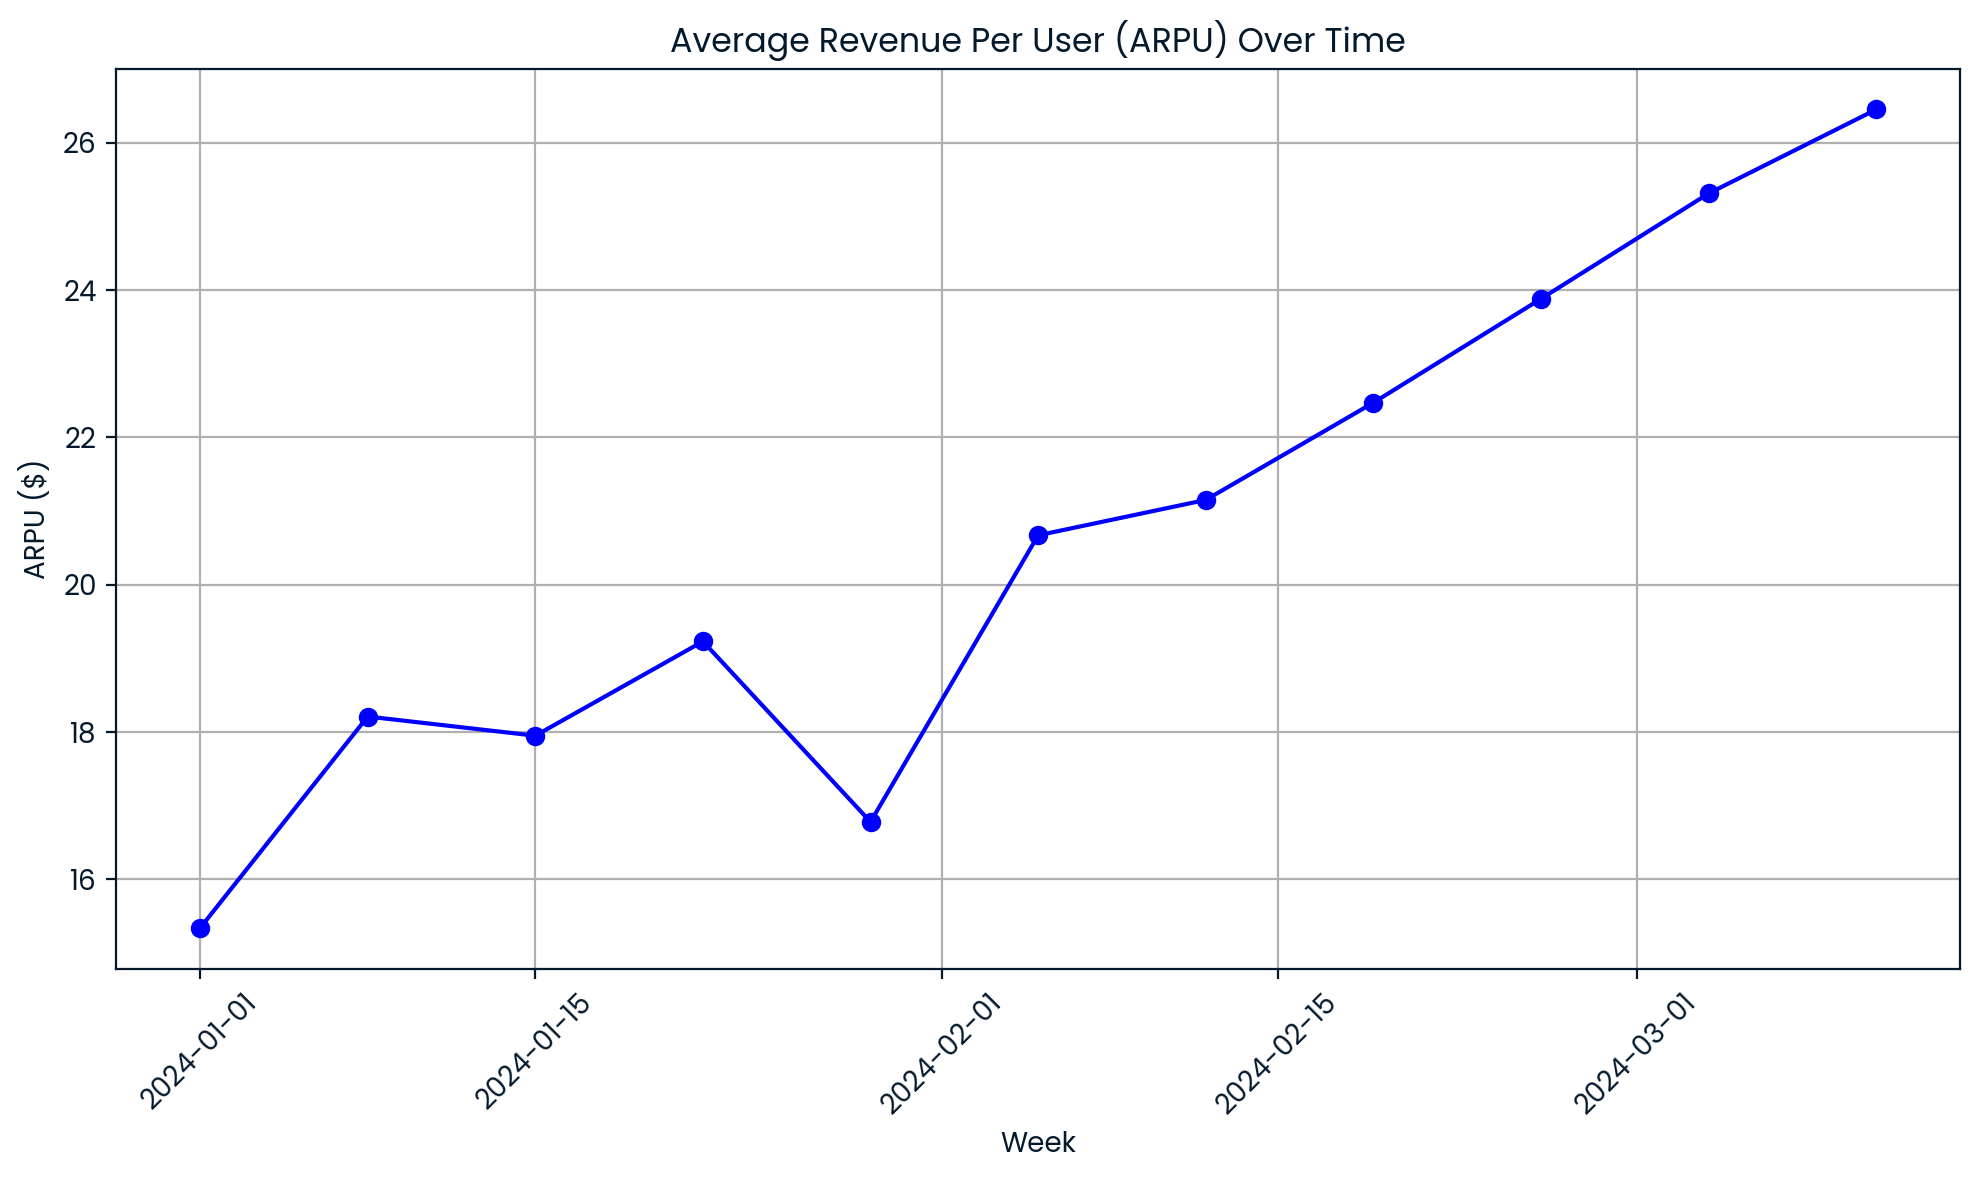

In [4]:
import matplotlib.pyplot as plt

import pandas as pd

from io import StringIO

# Sample data simulating the result of the SQL query

data = """

delivr_week,arpu

2024-01-01,15.34

2024-01-08,18.21

2024-01-15,17.95

2024-01-22,19.23

2024-01-29,16.78

2024-02-05,20.67

2024-02-12,21.15

2024-02-19,22.47

2024-02-26,23.88

2024-03-04,25.31

2024-03-11,26.45

"""

# Reading the data into a DataFrame

df = pd.read_csv(StringIO(data), parse_dates=["delivr_week"])

# Plotting the data

plt.figure(figsize=(10, 6))

plt.plot(df['delivr_week'], df['arpu'], marker='o', linestyle='-', color='blue')

plt.title('Average Revenue Per User (ARPU) Over Time')

plt.xlabel('Week')

plt.ylabel('ARPU ($)')

plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()

# Show the plot

plt.show()

### Average orders per user

It's a good idea to add the average orders per user value to the unit economics study since more orders usually correspond to more revenue.

In [5]:
WITH kpi AS (
  SELECT
    -- Select the count of orders and users
    COUNT (DISTINCT order_id) AS orders,
    COUNT (DISTINCT new_user_id) AS users
  FROM orders_modified_greater_variation.csv)
SELECT
  -- Calculate the average orders per user
  ROUND(
    orders :: NUMERIC / GREATEST(users, 1),
  2) AS arpu
FROM kpi;

,arpu
0,28.77


## Histograms

Understanding your dataset's distribution helps you understand which values are frequent and which are rare. The best way to visualize and understand a dataset’s distribution is to plot its histogram.

A histogram visualizes the frequencies of each value in a dataset. 

To get the frequency table, we need to calculate each user's count of orders. 
We need to count each user's distinct order IDs and store them in the user_orders CTE. 
Then, in the final query, we select the orders column and count the distinct user IDs for each order count. Also it is important to sort the results by the orders column in ascending order.

We can also get the frequency table of the revenues company  generated from each user by much the same method. In the CTE, calculate and store revenue instead of the count of orders for each user. 
In the final query, we round the revenue column (to the nearest hundred), group by it, and count the user IDs for each revenue value.

Histogram of revenue can give us important information about users. If the histogram is U-shaped, then there are many users who generate low revenue, and many who generate high revenue, but few who generate a median level of revenue. On the other hand, if the histogram is more normally shaped, then the opposite is true.

### Histogram of revenue query

In [6]:
WITH user_revenues AS (
  SELECT
    -- Select the user ID and revenue
    new_user_id,
    SUM(meal_price * order_quantity) AS revenue
  FROM meals.csv AS m
  JOIN orders_modified_greater_variation.csv AS o ON m.meal_id = o.meal_id
  GROUP BY new_user_id)

SELECT
  -- Return the frequency table of revenues by user
  ROUND(revenue :: NUMERIC, -2) AS revenue_100,
  COUNT(DISTINCT new_user_id) AS users
FROM user_revenues
GROUP BY revenue_100
ORDER BY revenue_100 ASC;

,revenue_100,users
0,0.0,309
1,100.0,327
2,200.0,37
3,300.0,6
4,400.0,6
5,500.0,3
6,600.0,2
7,700.0,5
8,800.0,2
9,900.0,3


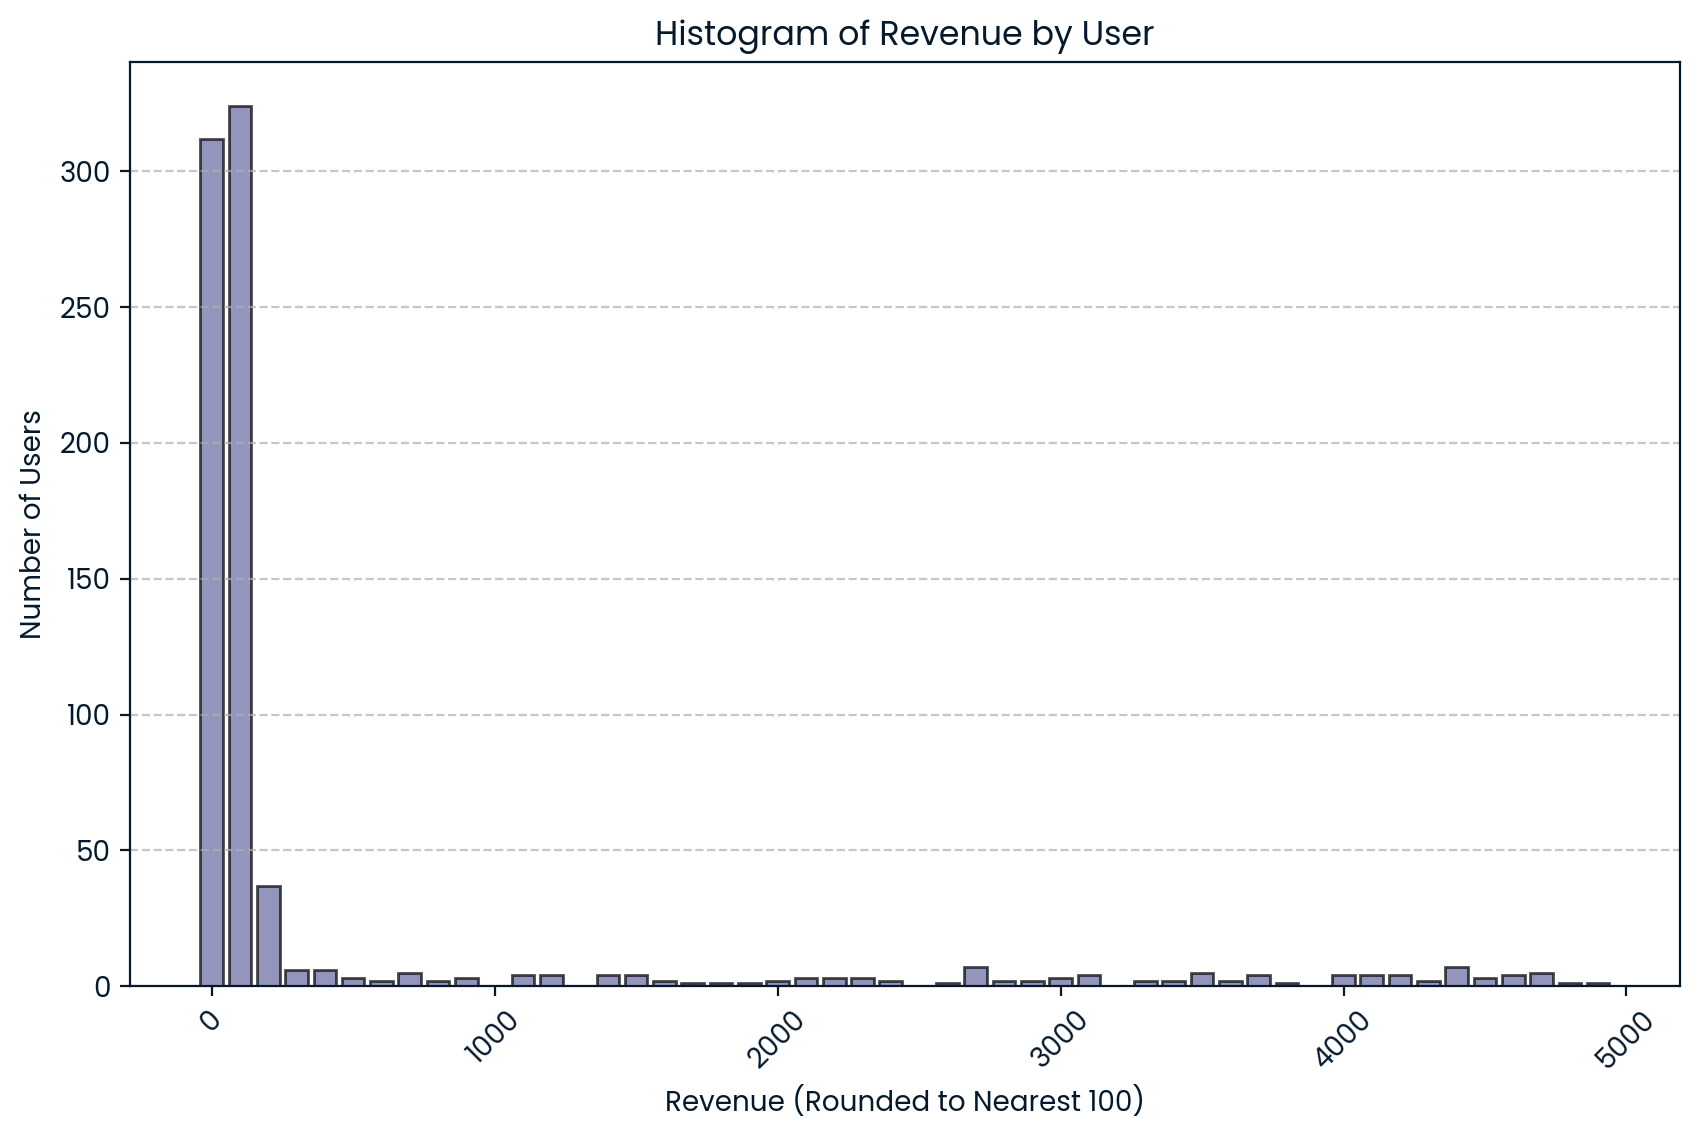

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
meals = pd.read_csv('meals.csv')
orders = pd.read_csv('orders_modified_greater_variation.csv')

# Perform the query using pandas
user_revenues = orders.merge(meals, on='meal_id')
user_revenues['revenue'] = user_revenues['meal_price'] * user_revenues['order_quantity']
user_revenues = user_revenues.groupby('new_user_id')['revenue'].sum().reset_index()

# Round the revenue to the nearest hundred
user_revenues['revenue_100'] = user_revenues['revenue'].round(-2)

# Create the frequency table
frequency_table = user_revenues.groupby('revenue_100')['new_user_id'].nunique().reset_index()
frequency_table.columns = ['revenue_100', 'users']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(frequency_table['revenue_100'], frequency_table['users'], width=80, edgecolor='k', alpha=0.7)
plt.xlabel('Revenue (Rounded to Nearest 100)')
plt.ylabel('Number of Users')
plt.title('Histogram of Revenue by User')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Histogram  of  orders

In [8]:
WITH user_orders AS (
  SELECT
    new_user_id,
    COUNT(DISTINCT order_id) AS orders
  FROM orders_modified_greater_variation.csv
  GROUP BY new_user_id
)

SELECT
  -- Return the frequency table of orders by user
  orders,
  COUNT(DISTINCT new_user_id) AS users
FROM user_orders
GROUP BY orders
ORDER BY orders ASC;

,orders,users
0,1,26
1,2,62
2,3,200
3,4,152
4,5,1
...,...,...
119,344,1
120,346,1
121,350,2
122,358,1


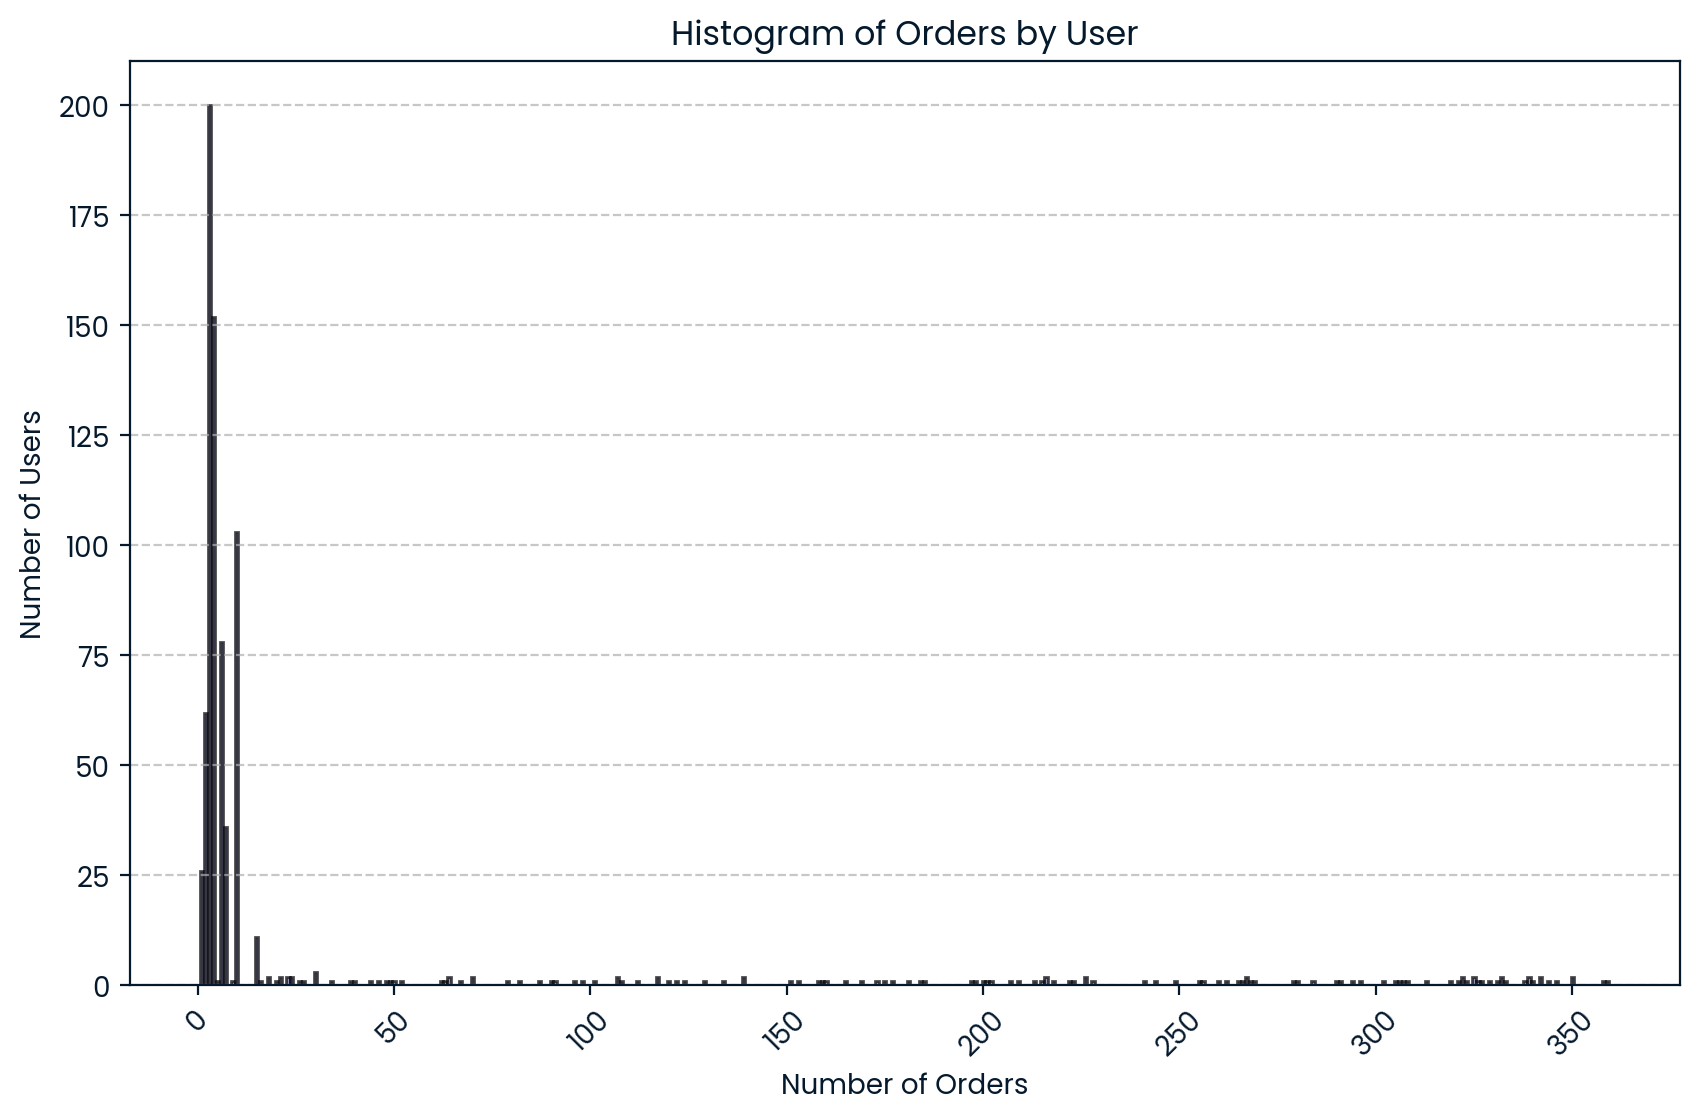

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
orders = pd.read_csv('orders_modified_greater_variation.csv')

# Perform the query using pandas
user_orders = orders.groupby('new_user_id')['order_id'].nunique().reset_index()
user_orders.columns = ['new_user_id', 'orders']

# Create the frequency table
frequency_table_orders = user_orders.groupby('orders')['new_user_id'].nunique().reset_index()
frequency_table_orders.columns = ['orders', 'users']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(frequency_table_orders['orders'], frequency_table_orders['users'], width=0.8, edgecolor='k', alpha=0.7)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.title('Histogram of Orders by User')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Bucketing

Bucketing allows you to summarize the frequency tables and present a dataset's distribution in a cleaner way.

### Bucketing  users  by  revenue

We split the users into low, mid, and high-revenue buckets, and return the count of users in each group.

In [10]:
WITH user_revenues AS (
  SELECT
    -- Select the user IDs and the revenues they generate
    new_user_id,
    SUM(meal_price * order_quantity) AS revenue
  FROM meals.csv AS m
  JOIN orders_modified_greater_variation.csv AS o ON m.meal_id = o.meal_id
  GROUP BY new_user_id
)

SELECT
  -- Fill in the bucketing conditions
  CASE
    WHEN revenue < 150 THEN 'Low-revenue users'
    WHEN revenue < 300 THEN 'Mid-revenue users'
    ELSE 'High-revenue users'
  END AS revenue_group,
  COUNT(DISTINCT new_user_id) AS users
FROM user_revenues
GROUP BY revenue_group;

,revenue_group,users
0,Mid-revenue users,43
1,Low-revenue users,636
2,High-revenue users,125


### Bucketing users by orders

In [1]:
-- Store each user's count of orders in a CTE named user_orders
WITH user_orders AS (
  SELECT
    new_user_id,
    COUNT(DISTINCT order_id) AS orders
  FROM orders_modified_greater_variation.csv
  GROUP BY new_user_id)

SELECT
  -- Write the conditions for the three buckets
  CASE
    WHEN orders < 8 THEN 'Low-orders users'
    WHEN orders < 15 THEN 'Mid-orders users'
    ELSE 'High-orders users'
  END AS order_group,
  -- Count the distinct users in each bucket
  COUNT(DISTINCT new_user_id) AS users
FROM user_orders
GROUP BY order_group;

,order_group,users
0,Low-orders users,555
1,High-orders users,145
2,Mid-orders users,104


## Percentiles

Percentiles help you understand what percentage of your dataset is beneath a certain value, and what percentage is at or above it.

Percentiles and quartiles are quick ways to determine values by which you can separate dataset into groups. They're also used to determine the skew of the data.

## Revenue quartiles

Quartiles are useful to pinpoint cutoff values in the dataset.

In [2]:
WITH user_revenues AS (
  -- Select the user IDs and their revenues
  SELECT
    new_user_id,
    SUM(meal_price * order_quantity) AS revenue
  FROM meals.csv AS m
  JOIN orders_modified_greater_variation.csv AS o ON m.meal_id = o.meal_id
  GROUP BY new_user_id)

SELECT
  -- Calculate the first, second, and third quartile
  ROUND(
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY revenue ASC) :: NUMERIC,
  2) AS revenue_p25,
  ROUND(
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY revenue ASC) :: NUMERIC,
  2) AS revenue_p50,
  ROUND(
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY revenue ASC) :: NUMERIC,
  2) AS revenue_p75,
  -- Calculate the average
  ROUND(AVG(revenue) :: NUMERIC, 2) AS avg_revenue
FROM user_revenues;

,revenue_p25,revenue_p50,revenue_p75,avg_revenue
0,40.0,61.75,135.31,475.38


## Revenue Interquartile Range (IQR)

Users outside the revenue IQR are outliers, and it is good to determine the number of "typical" users.

In [3]:
WITH user_revenues AS (
  SELECT
    -- Select user_id and calculate revenue by user 
    new_user_id,
    SUM(m.meal_price * o.order_quantity) AS revenue
  FROM meals.csv AS m
  JOIN orders_modified_greater_variation.csv AS o ON m.meal_id = o.meal_id
  GROUP BY new_user_id),
  quartiles AS (
  SELECT
    -- Calculate the first and third revenue quartiles
    ROUND(
      PERCENTILE_CONT(0.25) WITHIN GROUP
      (ORDER BY revenue ASC) :: NUMERIC,
    2) AS revenue_p25,
    ROUND(
      PERCENTILE_CONT(0.75) WITHIN GROUP
      (ORDER BY revenue ASC) :: NUMERIC,
    2) AS revenue_p75
  FROM user_revenues)

SELECT
  -- Count the number of users in the IQR
  COUNT(new_user_id) AS users
FROM user_revenues
CROSS JOIN quartiles
-- Only keep users with revenues in the IQR range
WHERE revenue :: NUMERIC >= 120.69
  AND revenue :: NUMERIC <= 268.31;

,users
0,98


# Generating a Report

## Formatting  dates 

In [4]:
SELECT DISTINCT
  -- Select the order date
  order_date,
  -- Format the order date
  STRFTIME('%A %d, %B %Y', order_date) AS format_order_date
FROM orders_modified_greater_variation.csv
ORDER BY order_date ASC
LIMIT 3;

,order_date,format_order_date
0,2018-06-01 00:00:00+00:00,"Friday 01, June 2018"
1,2018-06-02 00:00:00+00:00,"Saturday 02, June 2018"
2,2018-06-03 00:00:00+00:00,"Sunday 03, June 2018"


# Window functions for Reports

## Rank users by their count of orders

Create a report which user IDs have the most orders each month. The goal is to display only user ranks. The top 1 rank goes to the user with the most orders, the second-top 2 rank goes to the user with the second-most orders, and so on.

In [5]:
-- Set up the user_count_orders CTE
WITH user_count_orders AS (
  SELECT
    new_user_id,
    COUNT(DISTINCT order_id) AS count_orders
  FROM orders_modified_greater_variation.csv
  -- Only keep orders in August 2018
  WHERE DATE_TRUNC('month', order_date) = '2018-08-01'
  GROUP BY new_user_id)

SELECT
  -- Select user ID, and rank user ID by count_orders
  new_user_id,
  RANK() OVER (ORDER BY count_orders DESC) AS count_orders_rank
FROM user_count_orders
ORDER BY count_orders_rank ASC
-- Limit the user IDs selected to 3
LIMIT 3;

,new_user_id,count_orders_rank
0,62,1
1,58,1
2,98,1


## Pivoting

To pivot a table is to rotate that table around a pivot column. In other words, it's transposing a row into a column. Pivoting converts a long table with many rows and few columns, into a wide table, with fewer rows and more columns.

### Pivoting  user  revenues  by  month

In [ ]:
-- DuckDB does not support CREATE EXTENSION
-- Removed the CREATE EXTENSION statement

SELECT * FROM CROSSTAB($$
  SELECT
    new_user_id,
    DATE_TRUNC('month', order_date) :: DATE AS delivr_month,
    SUM(meal_price * order_quantity) :: FLOAT AS revenue
  FROM meals.csv
  JOIN orders_modified_greater_variation.csv ON meals.meal_id = orders_modified_greater_variation.csv.meal_id
  WHERE new_user_id IN (0, 1, 2, 3, 4)
    AND order_date < '2018-09-01'
  GROUP BY new_user_id, delivr_month
  ORDER BY new_user_id, delivr_month;
$$)
-- Select user ID and the months from June to August 2018
AS ct (new_user_id INT,
       "2018-06-01" FLOAT,
       "2018-07-01" FLOAT,
       "2018-08-01" FLOAT)
ORDER BY new_user_id ASC;

Error: Catalog Error: Table Function with name crosstab does not exist!
Did you mean "glob"?
LINE 4: SELECT * FROM CROSSTAB($$
                      ^

A report on the total costs by busineee unit in the last two months

In [6]:
SELECT
  -- Select business unit and calculate total cost
  eatery,
  DATE_TRUNC('month', stocking_date) :: DATE AS delivr_month,
  SUM(meal_cost * stocked_quantity) :: FLOAT AS cost
FROM meals.csv
JOIN stock.csv ON meals.meal_id = stock.meal_id
-- Keep only the records after October 2018
WHERE stocking_date > '2018-10-01'
GROUP BY eatery, delivr_month
ORDER BY eatery, delivr_month;

,eatery,delivr_month,cost
0,'Burgatorio',2018-11-01 00:00:00+00:00,2288.00
1,'Leaning Tower of Pizza',2018-11-01 00:00:00+00:00,3989.75


In [ ]:
-- Import tablefunc
CREATE EXTENSION IF NOT EXISTS tablefunc;

SELECT * FROM CROSSTAB($$
  SELECT
    -- Select eatery and calculate total cost
    eatery,
    DATE_TRUNC('month', stocking_date) :: DATE AS delivr_month,
    SUM(meal_cost * stocked_quantity) :: FLOAT AS cost
  FROM meals.csv
  JOIN stock.csv ON meals.meal_id = stock.meal_id
  -- Keep only the records after October 2018
  WHERE DATE_TRUNC('month', stocking_date) > '2018-10-01'
  GROUP BY eatery, delivr_month
  ORDER BY eatery, delivr_month;
$$)

-- Select the eatery and November and December 2018 as columns
AS ct (eatery TEXT,
       "2018-11-01" FLOAT,
       "2018-12-01" FLOAT)
ORDER BY eatery ASC;

### A final executive report about the rankings of business units by the number of unique users who order from them by quarter

In [7]:
WITH eatery_users AS (
  SELECT
    eatery,
    -- Format the order date so "2018-06-01" becomes "Q2 2018"
    ANY_VALUE(STRFTIME('%Y-%m-%d', order_date)) AS formatted_order_date,
    CASE
      WHEN CAST(STRFTIME('%m', order_date) AS INTEGER) IN (1, 2, 3) THEN 'Q1'
      WHEN CAST(STRFTIME('%m', order_date) AS INTEGER) IN (4, 5, 6) THEN 'Q2'
      WHEN CAST(STRFTIME('%m', order_date) AS INTEGER) IN (7, 8, 9) THEN 'Q3'
      ELSE 'Q4'
    END || ' ' || STRFTIME('%Y', order_date) AS delivr_quarter,
    -- Count unique users
    COUNT(DISTINCT new_user_id) AS users
  FROM meals.csv
  JOIN orders_modified_greater_variation.csv ON meals.meal_id = orders_modified_greater_variation.meal_id
  GROUP BY eatery, delivr_quarter
  ORDER BY delivr_quarter, users
)

SELECT
  -- Select eatery and quarter
  eatery,
  delivr_quarter,
  -- Rank rows, partition by quarter and order by users
  RANK() OVER
    (PARTITION BY delivr_quarter
     ORDER BY users DESC) :: INT AS users_rank
FROM eatery_users
ORDER BY delivr_quarter, users_rank;

,eatery,delivr_quarter,users_rank
0,'The Moon Wok',Q1 2019,1
1,'Bean Me Up Scotty',Q1 2019,2
2,'Leaning Tower of Pizza',Q1 2019,3
3,'Burgatorio',Q1 2019,4
4,'Life of Pie',Q1 2019,5
...,...,...,...
65,'Burgatorio',Q4 2020,1
66,'Leaning Tower of Pizza',Q4 2020,2
67,'The Moon Wok',Q4 2020,3
68,'Bean Me Up Scotty',Q4 2020,3


In [ ]:
-- Import tablefunc
CREATE EXTENSION IF NOT EXISTS tablefunc;

-- Pivot the previous query by quarter
SELECT * FROM CROSSTAB($$
  WITH eatery_users AS  (
    SELECT
      eatery,
      -- Format the order date so "2018-06-01" becomes "Q2 2018"
      TO_CHAR(order_date, '"Q"Q YYYY') AS delivr_quarter,
      -- Count unique users
      COUNT(DISTINCT new_user_id) AS users
    FROM meals.csv
    JOIN orders_modified_greater_variation.csv ON meals.meal_id = orders.meal_id
    GROUP BY eatery, delivr_quarter
    ORDER BY delivr_quarter, users)

  SELECT
    -- Select eatery and quarter
    eatery,
    delivr_quarter,
    -- Rank rows, partition by quarter and order by users
    RANK() OVER
      (PARTITION BY delivr_quarter
       ORDER BY users DESC) :: INT AS users_rank
  FROM eatery_users
  ORDER BY eatery, delivr_quarter;
$$)
-- Select the columns of the pivoted table
AS  ct (eatery TEXT,
        "Q2 2018" INT,
        "Q3 2018" INT,
        "Q4 2018" INT)
ORDER BY "Q4 2018";